Reloading Tuner from my_dir/fashion_mnist_classification/tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 320)               251200    
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                3210      
                                                                 
Total params: 254410 (993.79 KB)
Trainable params: 254410 (993.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 11s 6ms/step - loss: 0.2991 - accuracy: 0.8926 - val_loss: 0.3410 - val_accuracy: 0.8765
Epoch 2/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2931 - accuracy: 0.8951 - val_loss: 0.3356 - val_accuracy: 0.8798
Epoch 3/20
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2850 - accuracy: 0.8987 - val_loss: 0.3307 - val_accuracy: 0.8818
Epoch 4/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2784 - accuracy: 0.9007 - val_loss: 0.3324 - val_accuracy: 0.8813
Epoch 5/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2726 - accuracy: 0.9015 - val_loss: 0.3253 - val_accuracy: 0.8825
Epoch 6/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2673 - accuracy: 0.9039 - val_loss: 0.3207 - val_accuracy: 0.8862
Epoch 7/20
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2626 - accuracy: 0.9064 - val_loss: 0.3173 - val_accuracy: 0.88

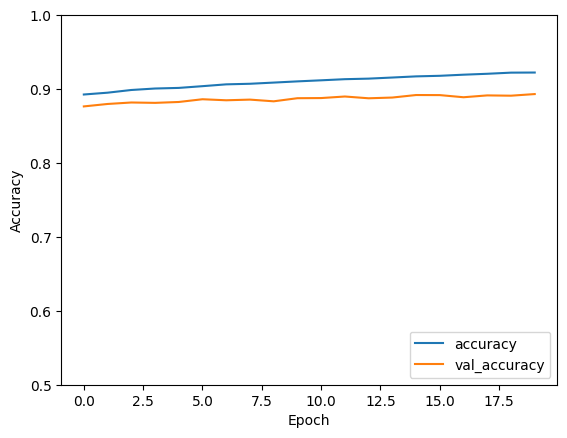

In [17]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras_tuner import RandomSearch
import kerastuner as kt

# Load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

# Define model builder function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu'))

    # Tune dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout))

    model.add(Dense(10, activation='softmax'))

    # Tune learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile model
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss=SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

# Hyperparameter tuning using Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Adjust as needed
    executions_per_trial=1,
    directory='my_dir',
    project_name='fashion_mnist_classification'
)

# Search for best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model.summary()

# Train the best model
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluate the best model on the test set
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Example of predictions
predictions = best_model.predict(X_test)

# Example of using the model for predictions
example_prediction = best_model.predict(X_test[:1])
print(f"Example prediction: {example_prediction}")

# Plotting the model loss and accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()
